In [1]:
import os
import numpy as np
#%matplotlib widget
import matplotlib.pyplot as plt
from scipy.optimize import fmin,fmin_l_bfgs_b,fmin_bfgs,fmin_cg,least_squares
from hapi import *
from spectral import *
import os
import spectral.io.envi as envi
from astropy.nddata import block_reduce
from scipy.interpolate import interp1d
import numba as nb
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans


HAPI version: 1.2.2.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

In [2]:
direct = os.getcwd()

hdrfile = os.path.join(direct,'f160112t01p00r10rdn_b_sc01_ort_img.hdr')
imgfile = os.path.join(direct,'f160112t01p00r10rdn_b_sc01_ort_img')

lib = envi.open(hdrfile)
img = envi.open(hdrfile,imgfile)

#p1=1810 ; p2 =2020 
#q1=380  ; q2 =500
p1=1810 ; p2 =2220 
q1=180  ; q2 =660

data_array = img[p1:p2,q1:q2,:]

hdrfile = os.path.join(direct,'f160112t01p00r10rdn_b_ort_igm.hdr')
imgfile = os.path.join(direct,'f160112t01p00r10rdn_b_ort_igm')

geo = envi.open(hdrfile,imgfile)
geo=np.array(geo[:,:,:],dtype=np.float64)

hdrfile = os.path.join(direct,'f160112t01p00r10rdn_b_ort_glt.hdr')
imgfile = os.path.join(direct,'f160112t01p00r10rdn_b_ort_glt')

geo_lut = envi.open(hdrfile,imgfile)
geo_lut = np.array(geo_lut[p1:p2,q1:q2,:],dtype=np.int64)

lon=np.zeros((data_array.shape[0:2]))
lat=np.zeros((data_array.shape[0:2]))
print(lon.shape)


#@nb.jit(fastmath=True)
def looper(geo_lut,geo,p,q):
    lon=np.zeros((geo_lut.shape[0:2]),dtype=np.float64)
    lat=np.zeros((geo_lut.shape[0:2]),dtype=np.float64)
    for i in range(p):
        for j in range(q):
            x=geo_lut[i,j,1]
            y=geo_lut[i,j,0]
            if(x>0 and y>0):
                lon[i,j] = np.float64(geo[x,y][0])
                lat[i,j] = np.float64(geo[x,y][1])
    return(lon,lat)
    
lon,lat = looper(geo_lut,geo,lon.shape[0],lon.shape[1])

lon[lon>-116] = np.nan
lon[lon<-121] = np.nan
lat[lat>36] = np.nan
lat[lat<29] = np.nan

print('data shape',data_array.shape)


(410, 480)
data shape (410, 480, 224)


In [3]:
filename=os.path.join(direct,'aviris_wvl.txt')
wvl=np.genfromtxt(filename)

idx = np.where(wvl>1500)[0]
wvl=wvl[idx]
data_array = data_array[:,:,idx]

idx = np.where(wvl<1700)[0]
wvl=wvl[idx]
data_array = data_array[:,:,idx]

print(wvl.shape,data_array.shape)

(20,) (410, 480, 20)


In [4]:
cm_min =1e7/np.nanmax(wvl)
cm_max =1e7/np.nanmin(wvl)

#fetch('CH4',6,1,cm_min-100,cm_max+100)
data = db_begin('CH4_Aviris')
nu,coef = absorptionCoefficient_Voigt(data,SourceTables='CH4', Diluent={'air':1.0},HITRAN_units=False)
nu,absorp = absorptionSpectrum(nu,coef,Environment={'T': 296.0, 'l': 1.0})

nu_,trans_,i1,i2,slit = convolveSpectrum(nu,absorp,SlitFunction=SLIT_GAUSSIAN,Resolution=10,AF_wing=50.0)


nu_=1e7/nu_

interp = interp1d(nu_,trans_)

Using CH4_Aviris

CH4
                     Lines parsed: 19545
{'air': 1.0}
7.200625 seconds elapsed for abscoef; nlines = 19545


In [5]:
r = data_array.T

b = interp(wvl)/1000
"""
maxi = np.nanmax(b)
b = b / maxi

norm = b.T @ b
b = b / np.sqrt(norm)
norm = b.T @ b
"""


'\nmaxi = np.nanmax(b)\nb = b / maxi\n\nnorm = b.T @ b\nb = b / np.sqrt(norm)\nnorm = b.T @ b\n'

In [6]:
# define k mean clusters
knn=10
model = KMeans(knn)
model.fit(np.nanmean(data_array,axis=2).flatten().reshape(-1,1))
pred = model.fit_predict(np.nanmean(data_array,axis=2).flatten().reshape(-1,1))


(410, 480) (410, 480, 20)


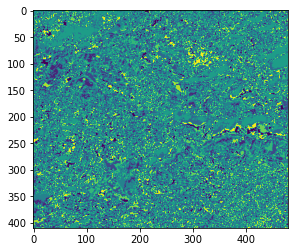

(410, 480)


In [7]:
pred=np.reshape(pred,(data_array.shape[0],data_array.shape[1]))
print(pred.shape,data_array.shape)
plt.imshow(pred)
plt.show()
print(pred.shape)

In [8]:
#create knn clusters
mu = np.zeros((knn,data_array.shape[2]))
for i in range(knn):
    mn = np.nanmean(data_array,axis=2).flatten()
    idx = np.logical_and(pred.flatten()==i,pred.flatten()==i)#[0]
    mu[i,:] = np.nanmean(mn[idx]) 


In [9]:
# frame number, let us say up direction, 'y'
data=data_array
alpha_x = np.zeros((data.shape[0],data.shape[1]))
for i in tqdm(range(data.shape[0])):
    r = data[i,:,:]
    #mu = np.nanmean(r,axis=0)
    #mu = np.nanmean(np.nanmean(data,axis=0),axis=0)

    # calculate covariance matrices
    K = np.zeros((mu.shape[1],mu.shape[1]))
    # loop over xtrack positions
    for j in range(data.shape[1]):
        pred_now = pred[i,j]
        p1 = r[j,:] - mu[pred_now,:]
        K[:,:] = K[:,:] + p1[...,np.newaxis] @ p1[...,np.newaxis].T

    K[:,:] = K[:,:] / r.shape[0]
    
    Kinv = np.linalg.inv(K) 

    #bnew = b*mu

    for j in range(data.shape[1]):
        pred_now = pred[i,j]
        bnew = b * mu[pred_now,:]
        p1 = (r[j,:] - mu[pred_now,:])
        p1 = p1[...,np.newaxis].T
        x=p1 @ Kinv @ bnew[...,np.newaxis]
        alpha_x[i,j] = p1 @ Kinv @ bnew[...,np.newaxis]
        denom = bnew[...,np.newaxis].T @ Kinv @ bnew[...,np.newaxis]
        alpha_x[i,j] = alpha_x[i,j] / denom
        #print(alpha_x[j,i])


100%|██████████| 410/410 [00:03<00:00, 122.02it/s]


(410,) (410,) (410, 480)
-5145343.895194946


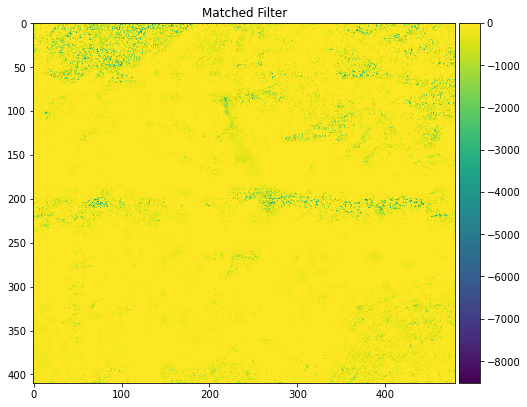

In [25]:

from MSATwtdenoiser import MSATdenoise

std = np.nanstd(denoised_img,axis=1)
mn = np.nanmean(denoised_img,axis=1)
print(mn.shape,std.shape,alpha_x.shape)

denoiser = MSATdenoise((alpha_x-mn[...,np.newaxis])/std[...,np.newaxis],'db3',3)
denoised_img = denoiser.denoised




print(np.nansum(alpha_x))

#idx=np.logical_and(abs(denoised_img)<(2*std+mn),abs(denoised_img)>(mn-2*std))

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)
#im1 = ax1.imshow((alpha_x-mn[...,np.newaxis])/std[...,np.newaxis],vmax=0)#,vmin=-400)
im1 = ax1.imshow(denoised_img,vmax=0)#,vmin=-400)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
ax1.set_title('Matched Filter')
fig.colorbar(im1, cax=cax, orientation='vertical')

"""
ax1 = fig.add_subplot(131)
im1 = ax1.imshow(alpha_x[:,:]*np.nanmean(data,axis=2),vmax=0)#,aspect='auto')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
ax1.set_title('Matched Filter')
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(132)
im2 = ax2.imshow(lon)#,aspect='auto')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
ax2.set_title('Longitude')
fig.colorbar(im2, cax=cax, orientation='vertical')

ax3 = fig.add_subplot(133)
im3 = ax3.imshow(lat)#,aspect='auto')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
ax3.set_title('Latitude')
fig.colorbar(im3, cax=cax, orientation='vertical')
"""

#display(fig)
plt.show()

In [96]:
# Let us plot it on GEE.
import make_kmz_v2
from palettable import colorbrewer

ModuleNotFoundError: No module named 'make_kmz_v2'

(610, 280)


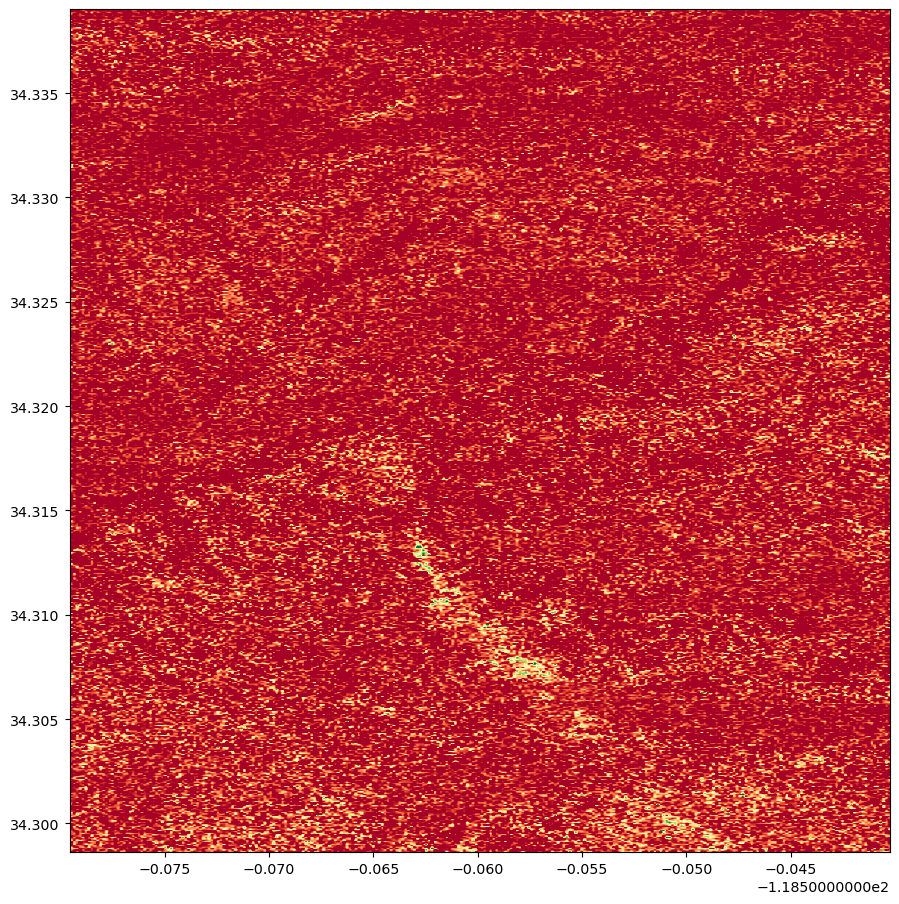

In [95]:
filter1d = alpha_x

idx=np.isfinite(lon)
print(idx.shape)


pixels = 1024 #* 10
cmap = colorbrewer.get_map('RdYlGn', 'diverging', 11, reverse=True).mpl_colormap

fig, ax = make_kmz_v2.gearth_fig(llcrnrlon=np.nanmin(lon),
                     llcrnrlat=np.nanmin(lat),
                     urcrnrlon=np.nanmax(lon),
                     urcrnrlat=np.nanmax(lat),
                     pixels=pixels)
cs = ax.imshow(alpha_x[:,:],vmax=0,vmin=-20, cmap=cmap,extent=[np.nanmin(lon), np.nanmax(lon),\
                                             np.nanmin(lat), np.nanmax(lat)])
plt.savefig('overlay1.png', transparent=False, format='png')


#name='avris_aliso_canyon_2016.kml'


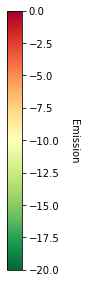

In [96]:
fig = plt.figure(figsize=(1.0, 4.0), facecolor=None, frameon=False)
ax = fig.add_axes([0.0, 0.05, 0.2, 0.9])
cb = fig.colorbar(cs, cax=ax)
cb.set_label('Emission', rotation=-90, color='k', labelpad=20)
fig.savefig('legend.png', transparent=False, format='png')  # Change transparent to True if your colorbar is not on space :)

In [97]:
make_kmz_v2.make_kml(llcrnrlon=np.nanmin(lon),
                     llcrnrlat=np.nanmin(lat),
                     urcrnrlon=np.nanmax(lon),
                     urcrnrlat=np.nanmax(lat),
         figs=['overlay1.png'], colorbar='legend.png',
         kmzfile='aviris_aliso_canyon_2016.kmz', name='CH4 Emission')